### import packages

In [1]:
import numpy as np
import torch
import copy
import pandas as pd
import SimpleITK as sitk
from PIL import Image
import pydicom
import cv2
import nibabel as nib
import os
import skimage.io as io

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from func.model_arch import SegAirwayModel
from func.model_run import get_image_and_label, get_crop_of_image_and_label_within_the_range_of_airway_foreground, \
semantic_segment_crop_and_cat, dice_accuracy
from func.post_process import post_process, add_broken_parts_to_the_result, find_end_point_of_the_airway_centerline, \
get_super_vox, Cluster_super_vox, delete_fragments, get_outlayer_of_a_3d_shape, get_crop_by_pixel_val, fill_inner_hole
from func.detect_tree import tree_detection
from func.ulti import save_obj, load_obj, get_and_save_3d_img_for_one_case,load_one_CT_img, \
get_df_of_centerline, get_df_of_line_of_centerline

### load data

[Option 1] get 3D image from DCM images

In [2]:
intput_img_path = "test_data/DCM_imgs" # these DCM images come from a dataset which was not used for training
raw_img_path = "results/raw_img.nii.gz"
get_and_save_3d_img_for_one_case(img_path = intput_img_path,
                                 output_file_path = raw_img_path) 

[Option 2] or you can directly load the 3D .nii.gz image if you already have it

In [3]:
raw_img_path = "test_data/test_image.nii.gz"

### load model

In [4]:
raw_img = load_one_CT_img(raw_img_path)

set the ```device``` to be used (CPU or GPU)

In [5]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [6]:
model=SegAirwayModel(in_channels=1, out_channels=2)
model.to(device)
load_path = "checkpoint/checkpoint.pkl"
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
model_semi_supervise_learning=SegAirwayModel(in_channels=1, out_channels=2)
model_semi_supervise_learning.to(device)
load_path = "checkpoint/checkpoint_semi_supervise_learning.pkl"
checkpoint = torch.load(load_path)
model_semi_supervise_learning.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### run on 3D image

In [8]:
threshold = 0.5

In [9]:
seg_result_semi_supervise_learning = semantic_segment_crop_and_cat(raw_img, model_semi_supervise_learning, device,
                                                                   crop_cube_size=[32, 128, 128], stride=[16, 64, 64],
                                                                   windowMin=-1000, windowMax=600)
seg_onehot_semi_supervise_learning = np.array(seg_result_semi_supervise_learning>threshold, dtype=np.int)

/tmp/ipykernel_11782/1843997031.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seg_onehot_semi_supervise_learning = np.array(seg_result_semi_supervise_learning>threshold, dtype=np.int)


In [10]:
# plt.figure(figsize=(20,20))
# plt.title("model output (top view)")
# plt.imshow(np.sum(seg_onehot_semi_supervise_learning, axis=1), cmap='gray')

In [11]:
seg_result = semantic_segment_crop_and_cat(raw_img, model, device,
                                           crop_cube_size=[32, 128, 128], stride=[16, 64, 64],
                                           windowMin=-1000, windowMax=600)
seg_onehot = np.array(seg_result>threshold, dtype=np.int)

/tmp/ipykernel_11782/586640011.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seg_onehot = np.array(seg_result>threshold, dtype=np.int)


In [12]:
# plt.figure(figsize=(20,20))
# plt.title("model output (top view)")
# plt.imshow(np.sum(seg_onehot, axis=1), cmap='gray')

In [13]:
seg_onehot_comb = np.array((seg_onehot+seg_onehot_semi_supervise_learning)>0, dtype=np.int)
seg_result_comb = (seg_result+seg_result_semi_supervise_learning)/2

/tmp/ipykernel_11782/4268311362.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seg_onehot_comb = np.array((seg_onehot+seg_onehot_semi_supervise_learning)>0, dtype=np.int)


2D visualization: show top view

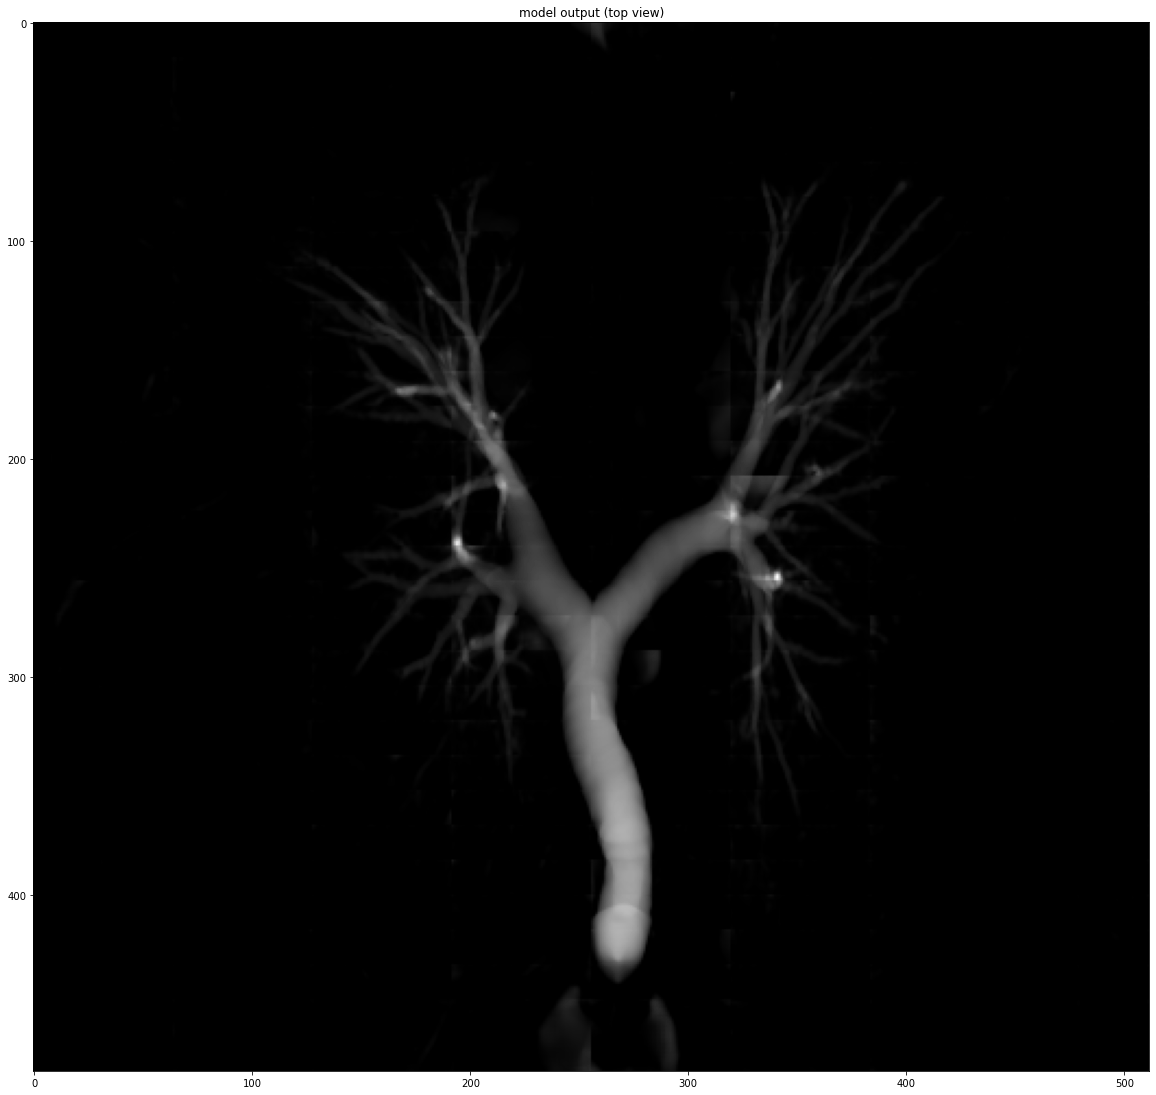

In [14]:
plt.figure(figsize=(20,20))
plt.title("model output (top view)")
plt.imshow(np.sum(seg_result_semi_supervise_learning, axis=1), cmap='gray')

2D visualization: chosen slice

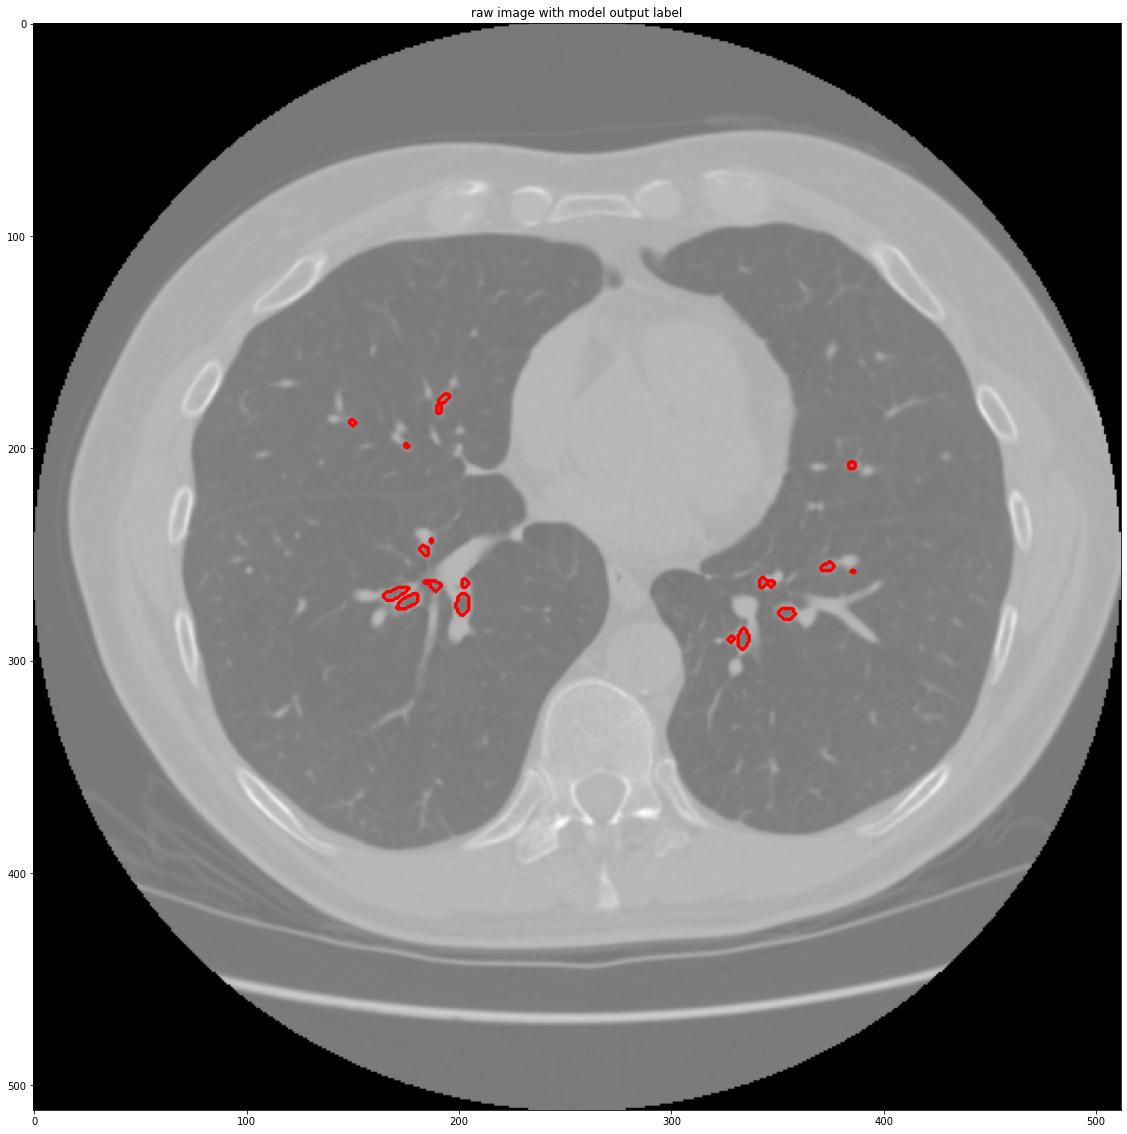

In [15]:
# choose the slice to show
# ----------
N=150
# ----------

plt.figure(figsize=(20,20))
plt.title("raw image with model output label")
plt.imshow(raw_img[N,:,:], cmap='gray')
plt.contour(seg_onehot_comb[N,:,:], colors='r', linestyles='-')

### post process I: find the max connected body

In [ ]:
seg_processed,_ = post_process(seg_onehot_comb, threshold=threshold)

valid_neighbor_vals: [ 707  772  821  822  828  851  871  903  939  946  947  948  954 1014 1015 1071 1112 1142]
Assign label 1245 to current val's neighbors: [ 707  772  821  822  828  851  871  903  939  946  947  948  954 1014
valid_neighbor_vals: [ 666  673  680  697  753  786  801  812  818  875  877  942  955  963
Assign label 1245 to current val's neighbors: [ 666  673  680  697  753  786  801  812  818  875  877  942  955  963
valid_neighbor_vals: [ 643  655  667  749  790  799  817  878  890  953  964 1026 1035 1102
Assign label 1245 to current val's neighbors: [ 643  655  667  749  790  799  817  878  890  953  964 1026 1035 1102
valid_neighbor_vals: [ 634  656  681  745  748  777  781  804  816  873  920  961  970  979
Assign label 1245 to current val's neighbors: [ 634  656  681  745  748  777  781  804  816  873  920  961  970  979
valid_neighbor_vals: [ 631  632  637  682  733  742  765  771  780  808  815  874  950  973
Assign label 1245 to current val's neighbors: [ 631

2D visualization: show top view

In [ ]:
plt.figure(figsize=(20,20))
plt.title("model output after post process I (top view)")
plt.imshow(np.sum(seg_processed, axis=1), cmap='gray')

2D visualization: chosen slice

In [ ]:
# choose the slice to show
# ----------
N=200
# ----------

plt.figure(figsize=(20,20))
plt.title("raw image with label after post process I")
plt.imshow(raw_img[N,:,:], cmap='gray')
plt.contour(seg_processed[N,:,:], colors='r', linestyles='-')

### airway centerline detection

In [ ]:
seg_slice_label_I, connection_dict_of_seg_I, number_of_branch_I, tree_length_I = tree_detection(seg_processed, search_range=2)

3D visualization: show centerline

In [ ]:
# # show the airway centerline
# def get_df_of_centerline(connection_dict):
#     d = {}
#     d["x"] = []
#     d["y"] = []
#     d["z"] = []
#     d["val"] = []
#     d["text"] = []
#     for item in connection_dict.keys():
#         print(item, end="\r")
#         d["x"].append(connection_dict[item]['loc'][0])
#         d["y"].append(connection_dict[item]['loc'][1])
#         d["z"].append(connection_dict[item]['loc'][2])
#         d["val"].append(connection_dict[item]['generation'])
#         d["text"].append(str(item)+": "+str({"before":connection_dict[item]["before"], "next":connection_dict[item]["next"]}))
#     df = pd.DataFrame(data=d)
#     return df

# # show the airway centerline
# def get_df_of_line_of_centerline(connection_dict):
#     d = {}
#     for label in connection_dict.keys():
#         if connection_dict[label]["before"][0]==0:
#             start_label = label
#             break
#     def get_next_point(connection_dict, current_label, d, idx):
#         while (idx in d.keys()):
#             idx+=1
        
#         d[idx]={}
#         if "x" not in d[idx].keys():
#             d[idx]["x"]=[]
#         if "y" not in d[idx].keys():
#             d[idx]["y"]=[]
#         if "z" not in d[idx].keys():
#             d[idx]["z"]=[]
#         if "val" not in d[idx].keys():
#             d[idx]["val"]=[]
        
#         before_label = connection_dict[current_label]["before"][0]
#         if before_label not in connection_dict.keys():
#             before_label = current_label
#         d[idx]["x"].append(connection_dict[before_label]["loc"][0])
#         d[idx]["y"].append(connection_dict[before_label]["loc"][1])
#         d[idx]["z"].append(connection_dict[before_label]["loc"][2])
#         d[idx]["val"].append(connection_dict[before_label]["generation"])
        
#         d[idx]["x"].append(connection_dict[current_label]["loc"][0])
#         d[idx]["y"].append(connection_dict[current_label]["loc"][1])
#         d[idx]["z"].append(connection_dict[current_label]["loc"][2])
#         d[idx]["val"].append(connection_dict[current_label]["generation"])
        
#         if connection_dict[current_label]["number_of_next"]==0:
#             return
#         else:
#             for next_label in connection_dict[current_label]["next"]:
#                 get_next_point(connection_dict, next_label, d, idx+1)
    
#     get_next_point(connection_dict, start_label, d,0)
#     return d

In [ ]:
df_of_line_of_centerline = get_df_of_line_of_centerline(connection_dict_of_seg_I)

fig = go.Figure()

for item in df_of_line_of_centerline.keys():
    fig.add_trace(go.Scatter3d(x=df_of_line_of_centerline[item]["x"],
                               y=df_of_line_of_centerline[item]["y"],
                               z=df_of_line_of_centerline[item]["z"],mode='lines'))

fig.show("notebook")

### post process II: find the broken airway branches

In [ ]:
seg_processed_II = add_broken_parts_to_the_result(connection_dict_of_seg_I, seg_result_comb, seg_processed, threshold = threshold,
                                                  search_range = 10, delta_threshold = 0.05, min_threshold = 0.4)

2D visualization: show top view

In [ ]:
plt.figure(figsize=(20,20))
plt.title("model output after post process II (top view)")
plt.imshow(np.sum(seg_processed_II, axis=1), cmap='gray')

centerline re-detection

In [ ]:
seg_slice_label_II, connection_dict_of_seg_II, number_of_branch_II, tree_length_II = tree_detection(seg_processed_II, search_range=2)

3D visualization: show centerline

In [ ]:
df_of_line_of_centerline = get_df_of_line_of_centerline(connection_dict_of_seg_II)

fig = go.Figure()

for item in df_of_line_of_centerline.keys():
    fig.add_trace(go.Scatter3d(x=df_of_line_of_centerline[item]["x"],
                               y=df_of_line_of_centerline[item]["y"],
                               z=df_of_line_of_centerline[item]["z"],mode='lines'))

fig.show("notebook")

# save the centerline result
fig.write_html("results/seg_result_centerline.html")

### save the results

In [ ]:
output_file_path = "results"

In [ ]:
sitk.WriteImage(sitk.GetImageFromArray(seg_processed),output_file_path+"/segmentation.nii.gz")
sitk.WriteImage(sitk.GetImageFromArray(seg_processed_II),output_file_path+"/segmentation_add_broken_parts.nii.gz")

### save the results as 3d obj

In [ ]:
from func.points_to_mesh import produce_3d_obj

In [ ]:
produce_3d_obj(seg_processed, output_file_path+"/segmentation")

In [ ]:
produce_3d_obj(seg_processed_II, output_file_path+"/segmentation_add_broken_parts")